In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from ase.data import chemical_symbols
from tqdm import tqdm_notebook as tqdm
import csv

from ase import Atoms
from ase.io import read
from potentials import Lobato, Kirkland, slice_potential

import time
from pyqstem import PyQSTEM

In [2]:
atoms = read('graphene.cif', index = 0) # atomic configuration
rho = np.load('graphene.npy')
grid = rho.shape
Nx,Ny = grid[:2]

Lz = atoms.get_cell()[2,2]

In [18]:
filename = 'kirkland.csv'

with open(filename, 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')

    parameters = {}
    for i in range(103):
        symbol = chemical_symbols[i + 1]
        parameters[symbol] = {}
        element_data = []
        for _ in range(3):
            element_data += [float(r) for r in next(reader)]
        parameters[symbol]['a'] = element_data[0:6:2]
        parameters[symbol]['b'] = element_data[1:6:2]
        parameters[symbol]['c'] = element_data[6::2]
        parameters[symbol]['d'] = element_data[7::2]

with open('kirkland.txt', 'w') as f:
    for i in range(1,104):
        symbol = chemical_symbols[i]
        print(','.join(map(str,[i]+parameters[symbol]['a']+parameters[symbol]['b']+
                      parameters[symbol]['c']+parameters[symbol]['d'])), file=f)

In [19]:
parameters

{'Ac': {'a': [1.45864127, 4.18945405, 3.65866182],
  'b': [0.107760494, 88.9090649, 1.05088931],
  'c': [0.208479229, 3.16528117, 0.0523892556],
  'd': [0.0909335557, 31.3297788, 0.0208807697]},
 'Ag': {'a': [2.0798139, 0.443170726, 1.96515215],
  'b': [9.92540297, 0.104920104, 0.640103839],
  'c': [0.596130591, 0.478016333, 0.094645847],
  'd': [0.88959479, 1.98509407, 0.112744464]},
 'Al': {'a': [0.777419424, 0.0578312036, 0.426386499],
  'b': [2.71058227, 71.7532098, 0.0913331555],
  'c': [0.11340722, 0.790114035, 0.0323293496],
  'd': [0.448867451, 8.66366718, 0.178503463]},
 'Am': {'a': [5.38321999, 0.123343236, 3.4646909],
  'b': [10.7289857, 0.0415137806, 0.339326208],
  'c': [0.175437132, 3.39800073, 0.469459519],
  'd': [0.0998932346, 21.1601535, 0.45199697]},
 'Ar': {'a': [1.06983288, 0.424631786, 0.243897949],
  'b': [0.287791022, 12.4156957, 12.4158868],
  'c': [0.0479446296, 0.764958952, 0.0082312843],
  'd': [0.136979796, 2.43940729, 0.0527258749]},
 'As': {'a': [0.777875

In [6]:
qstem=PyQSTEM('TEM')
qstem.set_atoms(atoms)
qstem.build_wave('plane',300,(Nx,Ny))
qstem.build_potential(24)
V_qstem=qstem.get_potential_or_transfunc().array.real

V_qstem = np.sum(V_qstem, axis=2) * ((5.2917721067e-1 * 1) / (2 * 7.957747155e-2))

In [7]:
lobato_calc = Lobato(atoms, grid, units='atomic')
kirkland_calc = Kirkland(atoms, grid, units='atomic')

TypeError: __init__() missing 1 required positional argument: 'parameters'

In [60]:
V_lobato = lobato_calc.calc_from_splines(v_min=1e-2, r_min=.001)
V_kirkland = kirkland_calc.calc_from_splines(v_min=1e-2, r_min=.001)

V_lobato,_ = slice_potential(V_lobato, 1, Lz)
V_kirkland,_= slice_potential(V_kirkland, 1, Lz)

V_lobato = V_lobato[...,0]
V_kirkland = V_kirkland[...,0]

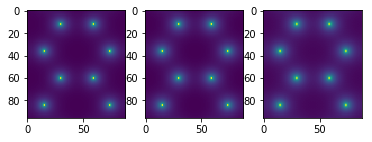

In [61]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3)

ax1.imshow(V_lobato, vmin=0, vmax=40)
ax2.imshow(V_kirkland, vmin=0, vmax=40)
ax3.imshow(V_qstem, vmin=0, vmax=40)
#ax3.imshow(np.sum(V_lobato - V_qstem, axis=2).T, vmin=-1, vmax=1)


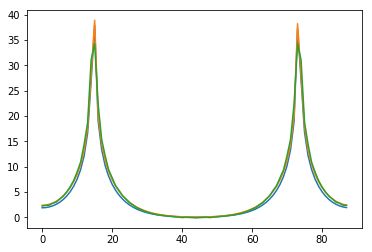

In [62]:
plt.plot(V_lobato[36,:])
plt.plot(V_kirkland[36,:])
plt.plot(V_qstem[36,:]-.8)